## Check datatsets

Первоначально я выбрала дасет с каггла. У этого датасета отличного качества чертежи. Однако дальнейший анализ датасеат показал что качество разметки просто ниже плинтуса. Фактически это фрод. Я сделала репорт на этот датасет.

In [1]:
import os
from dotenv import load_dotenv

APP_FOLDER = "../"
load_dotenv(os.path.join(APP_FOLDER, ".env"))

True

In [2]:
from pathlib import Path

DATA_RAW = os.getenv("DATA_RAW")
DATA_FILE = os.getenv("DATA_FILE")

images = os.path.join(APP_FOLDER, DATA_RAW, "FloorPlanCAD_YOLOv8_Full", "images")
labels = os.path.join(APP_FOLDER, DATA_RAW, "FloorPlanCAD_YOLOv8_Full", "labels")
data = os.path.join(APP_FOLDER, DATA_RAW, "FloorPlanCAD_YOLOv8_Full", DATA_FILE)

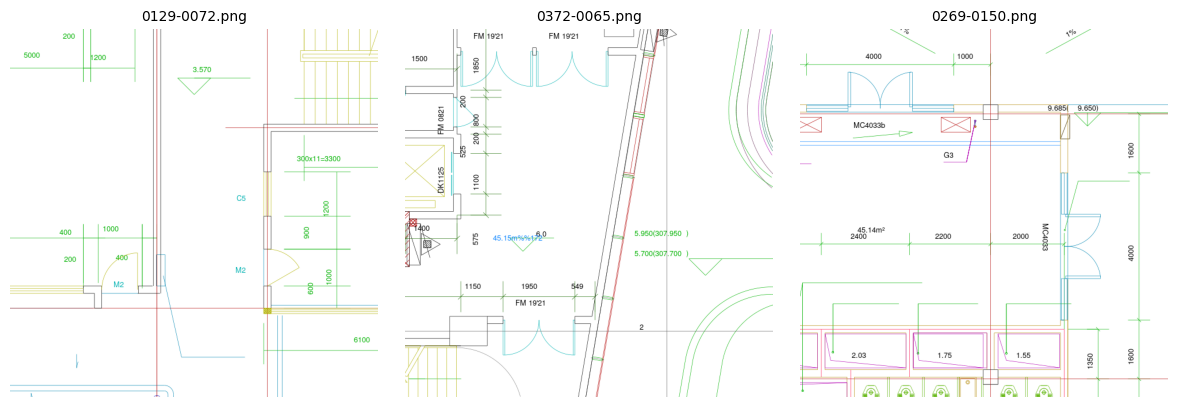

In [12]:
import random
from PIL import Image
import matplotlib.pyplot as plt

paths = list(Path(images).rglob("*.png"))
pick = random.sample(paths, k=min(3, len(paths)))

plt.figure(figsize=(12, 4))
for i, p in enumerate(pick, 1):
    img = Image.open(p)
    
    if img.mode in ("RGBA", "LA") or ("transparency" in img.info):
        img = img.convert("RGBA")
        white = Image.new("RGBA", img.size, (255, 255, 255, 255))
        img = Image.alpha_composite(white, img).convert("RGB")
    else:
        img = img.convert("RGB")
        
    ax = plt.subplot(1, 3, i)
    ax.imshow(img)
    ax.set_title(p.name, fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [3]:
from pathlib import Path
import pandas as pd

def build_df(images_dir, labels_dir):
    images_dir = Path(images_dir)
    labels_dir = Path(labels_dir)

    img = {p.stem: p for p in images_dir.rglob("*.png")}
    lbl = {p.stem: p for p in labels_dir.rglob("*.txt")}

    stems = sorted(set(img) & set(lbl))

    rows = []
    for s in stems:
        class_indices = []
        bboxes = []

        for line in lbl[s].read_text(encoding="utf-8", errors="ignore").splitlines():
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            class_indices.append(int(float(parts[0])))
            bboxes.append([float(x) for x in parts[1:]])

        rows.append({
            "file": s,
            "image_path": str(img[s]),
            "label_path": str(lbl[s]),
            "class_indices": class_indices,
            "bboxes": bboxes,
        })

    return pd.DataFrame(rows)

In [4]:
img_df = build_df(images, labels)
img_df.sample(2)

,file,image_path,label_path,class_indices,bboxes
14974,1299-1322,..\src\data\raw\FloorPlanCAD_YOLOv8_Full\image...,..\src\data\raw\FloorPlanCAD_YOLOv8_Full\label...,[0],"[[0.98085, 0.653656, 0.0383, 0.14]]"
9906,0726-0223,..\src\data\raw\FloorPlanCAD_YOLOv8_Full\image...,..\src\data\raw\FloorPlanCAD_YOLOv8_Full\label...,"[0, 7]","[[0.5, 0.094861, 1.0, 0.03], [0.5, 0.372361, 1..."


In [5]:
import yaml

with open(data, "r", encoding="utf-8") as f:
    names = yaml.safe_load(f)["names"]

id2class = {i: n for i, n in enumerate(names)}

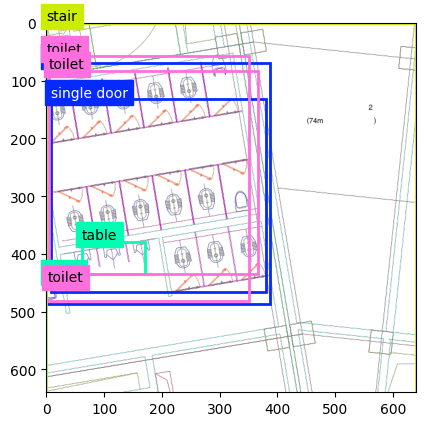

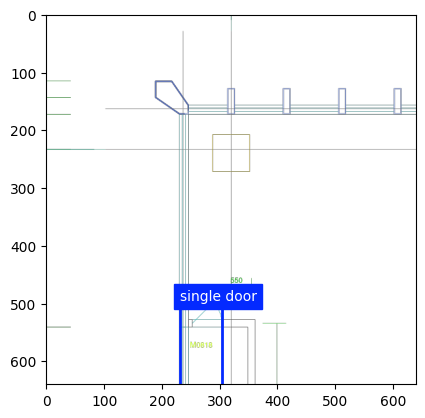

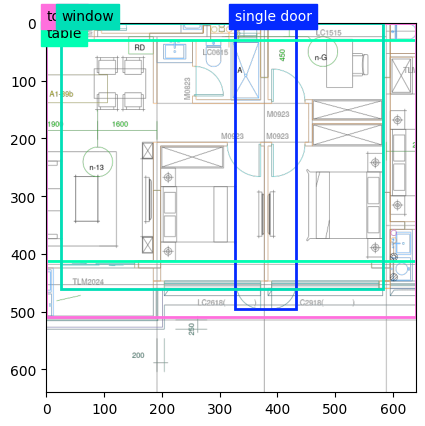

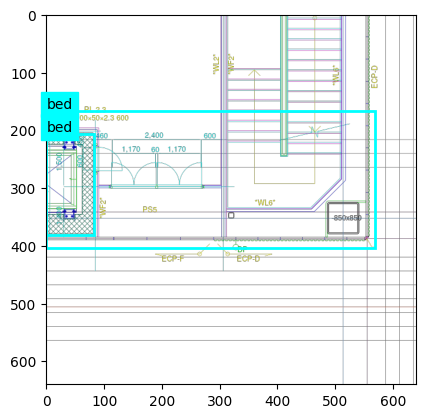

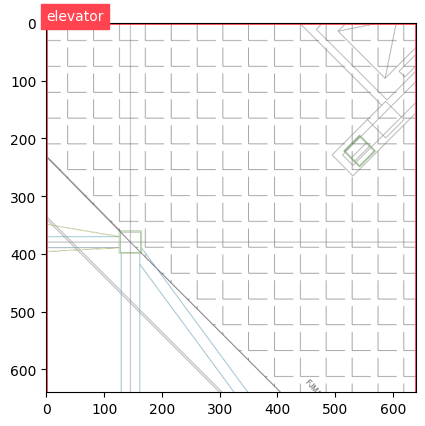

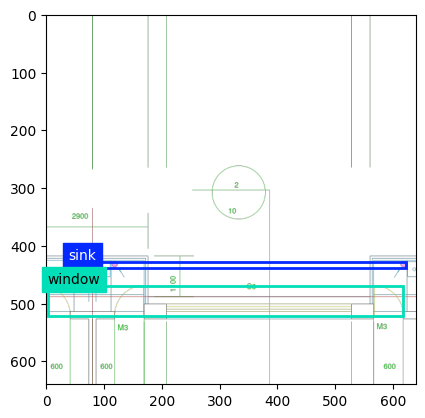

In [6]:
from ultralytics.data.utils import visualize_image_annotations

# 6 рандомных, по одной картинке за вызов
for _, r in img_df.sample(6, random_state=None).iterrows():
    visualize_image_annotations(r["image_path"], r["label_path"], id2class)

Поэтому пришлось искать другой датасет. В этом качестве чертежей намного ниже, колличество изображений около 1к, что сильно меньше. Но я надеюсь что для моей задачи его хватит.

In [7]:
images = os.path.join(APP_FOLDER, DATA_RAW, "Floorplan_details_Fork")
labels = os.path.join(APP_FOLDER, DATA_RAW, "Floorplan_details_Fork")
data = os.path.join(APP_FOLDER, DATA_RAW, "Floorplan_details_Fork", DATA_FILE)

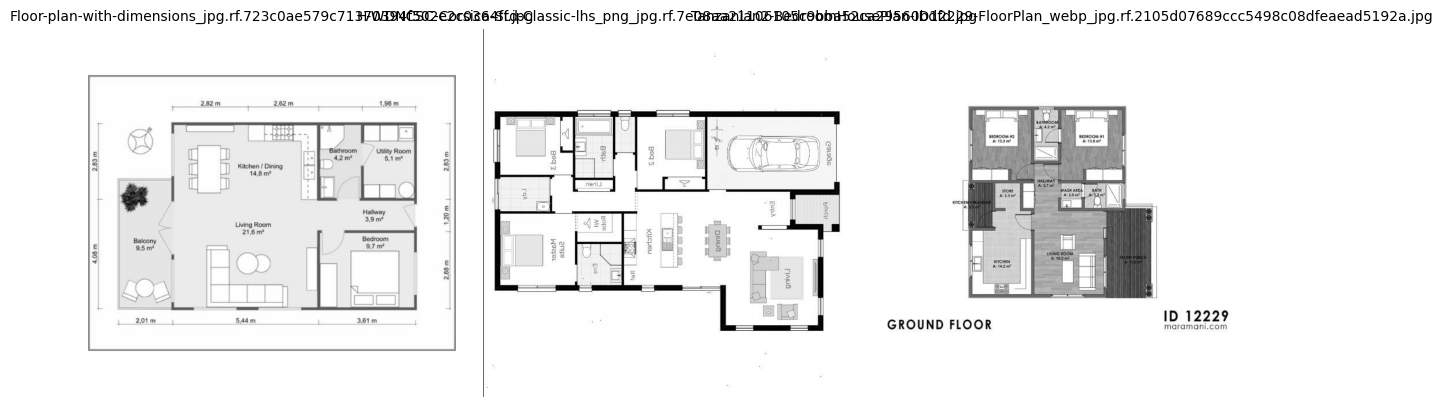

In [11]:
import random
from PIL import Image
import matplotlib.pyplot as plt

paths = list(Path(images).rglob("*.jpg"))
pick = random.sample(paths, k=min(3, len(paths)))

plt.figure(figsize=(12, 4))
for i, p in enumerate(pick, 1):
    img = Image.open(p).convert("RGB")
    ax = plt.subplot(1, 3, i)
    ax.imshow(img)
    ax.set_title(p.name, fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [12]:
from pathlib import Path
import pandas as pd
from PIL import Image

def build_df(images_dir, labels_dir):
    images_dir = Path(images_dir)
    labels_dir = Path(labels_dir)

    img = {p.stem: p for p in images_dir.rglob("*.jpg")}
    lbl = {p.stem: p for p in labels_dir.rglob("*.txt")}

    stems = sorted(set(img) & set(lbl))

    rows = []
    for s in stems:
        split = img[s].parent.parent.name

        with Image.open(img[s]) as im:
            width, height = im.size
            channels = len(im.getbands())

        class_indices = []
        bboxes = []

        for line in lbl[s].read_text(encoding="utf-8", errors="ignore").splitlines():
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            class_indices.append(int(float(parts[0])))
            bboxes.append([float(x) for x in parts[1:]])

        rows.append({
            "file": s,
            "split": split,
            "image_path": str(img[s]),
            "label_path": str(lbl[s]),
            "width": width,
            "height": height,
            "channels": channels,
            "class_indices": class_indices,
            "bboxes": bboxes,
        })

    return pd.DataFrame(rows)

In [13]:
img_df = build_df(images, labels)
img_df.sample(2)

,file,split,image_path,label_path,width,height,channels,class_indices,bboxes
248,5c19a14b001cf3-03205886186_jpg.rf.535ddeb68fb8...,train,..\src\data\raw\Floorplan_details_Fork\train\i...,..\src\data\raw\Floorplan_details_Fork\train\l...,640,640,3,"[13, 14, 0, 4, 2, 11, 7, 2, 0, 13, 14, 4, 12, ...","[[0.45625, 0.7671875, 0.0453125, 0.065625], [0..."
82,2023-Barcelona24-Standard-Classic-LHS_1_jpg.rf...,train,..\src\data\raw\Floorplan_details_Fork\train\i...,..\src\data\raw\Floorplan_details_Fork\train\l...,640,640,3,"[13, 2, 2, 2, 14, 14, 7, 7, 13, 0, 9, 3, 3, 3,...","[[0.33125, 0.528125, 0.01875, 0.028125], [0.38..."


In [14]:
import yaml

with open(data, "r", encoding="utf-8") as f:
    names = yaml.safe_load(f)["names"]

id2class = {i: n for i, n in enumerate(names)}

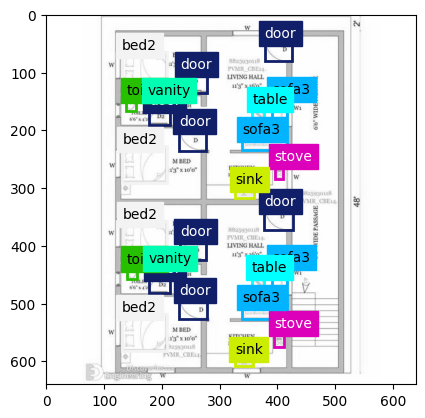

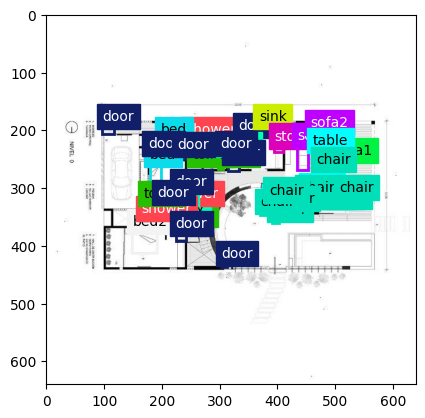

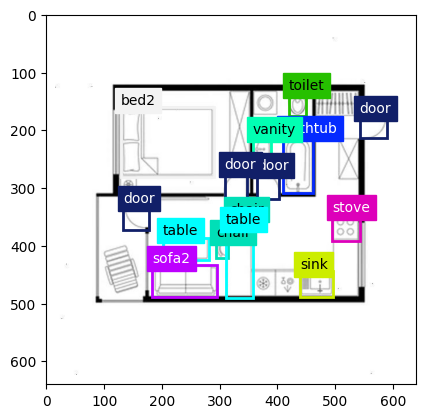

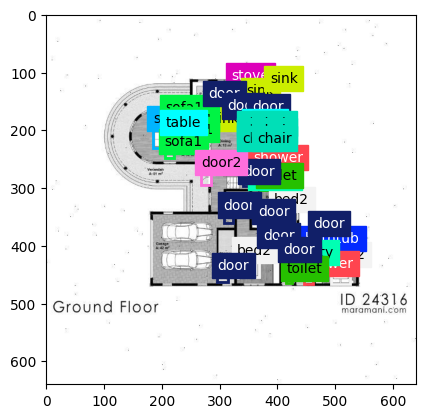

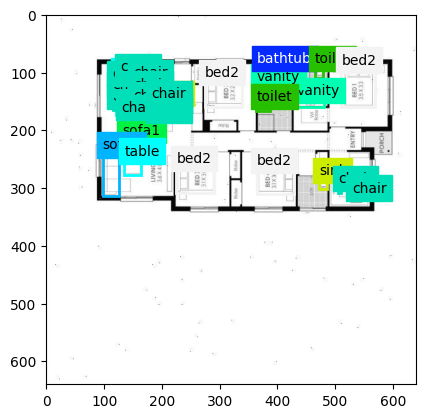

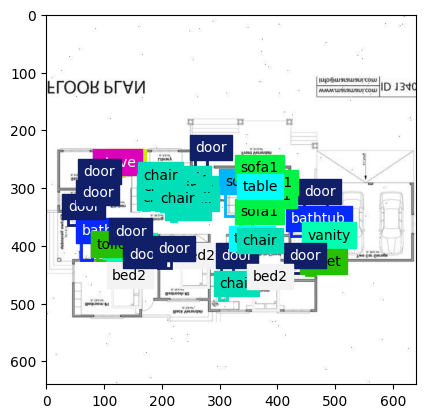

In [15]:
def is_bbox_correct(txt_path: str) -> bool:
    with open(txt_path, encoding="utf-8", errors="ignore") as f:
        for line in f:
            p = line.strip().split()
            if not p:
                continue
            if len(p) != 5:
                return False
    return True

bbox_df = img_df[img_df["label_path"].apply(is_bbox_correct)]

for _, r in bbox_df.sample(min(6, len(bbox_df))).iterrows():
    visualize_image_annotations(r["image_path"], r["label_path"], id2class)

Выяснилась еще одна проблема в лейблах многие разметки по какой-то причине хранят более 4 точек координат. Я не знаю как это интерпретировать и буду просто фильтровать везде такие записи.

In [16]:
import pandas as pd

counts = img_df["bboxes"].explode().dropna().map(len)

vc = counts.value_counts().sort_index()
print(vc)

n4 = int((counts == 4).sum())
n_other = int((counts != 4).sum())
print(f"\ncoords==4: {n4}")
print(f"coords!=4: {n_other}")

bboxes
4     24996
8         2
10      565
12      130
14       46
16       50
18       22
20       40
22        9
24        3
28        6
30        3
32        3
38        3
40        3
42        6
Name: count, dtype: int64

coords==4: 24996
coords!=4: 891


In [17]:
def filter_bbox_inplace(df):
    def keep_row(r):
        out_cls, out_bbox = [], []
        for c, coords in zip(r["class_indices"], r["bboxes"]):
            if len(coords) == 4:
                out_cls.append(c)
                out_bbox.append(coords)

        return pd.Series({"class_indices": out_cls, "bboxes": out_bbox})

    df[["class_indices", "bboxes"]] = df.apply(keep_row, axis=1)
    return df

In [18]:
img_df = filter_bbox_inplace(img_df)

In [19]:
counts = img_df["bboxes"].explode().dropna().map(len)

vc = counts.value_counts().sort_index()
print(vc)

bboxes
4    24996
Name: count, dtype: int64


## Save dataset

In [20]:
from pathlib import Path
import shutil

def export_yolo(df, data_dir):
    data_dir = Path(data_dir)

    for r in df.itertuples(index=False):
        img_src = Path(r.image_path)
        split = r.split

        img_dst = data_dir / split / "images" / img_src.name
        lbl_dst = data_dir / split / "labels" / f"{r.file}.txt"

        img_dst.parent.mkdir(parents=True, exist_ok=True)
        lbl_dst.parent.mkdir(parents=True, exist_ok=True)

        shutil.copy2(img_src, img_dst)

        lines = [
            f"{cls} {x:.10g} {y:.10g} {w:.10g} {h:.10g}"
            for cls, (x, y, w, h) in zip(r.class_indices, r.bboxes)
        ]
        lbl_dst.write_text("\n".join(lines) + ("\n" if lines else ""), encoding="utf-8")

In [22]:
DATA_CLEAN = os.getenv("DATA_CLEAN")

data_clean_dir = os.path.join(APP_FOLDER, DATA_CLEAN)

In [23]:
import shutil

export_yolo(img_df, data_clean_dir)
shutil.copy2(data, os.path.join(data_clean_dir, DATA_FILE));